In [297]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [293]:
!pip -q install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [275]:
df=pd.read_pickle('Original.pkl')

In [276]:
df.head(1)

,file_path,features,labels
0,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...,"[-697.7926025390625, 54.89004135131836, 0.6634...",01


In [277]:
df.drop('file_path',inplace=True,axis=1)

In [278]:
x=df.drop('labels',axis=1)
y=df['labels']

In [279]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [280]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [281]:
x_train = np.array(x_train['features'])
x_test = np.array(x_test['features'])

In [282]:
x_train=np.stack(x_train)
x_test=np.stack(x_test)

In [283]:
x_train.shape

(1961, 556)

In [284]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [285]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [414]:
pca = PCA(n_components=.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
print("PCA-reduced shape:Train", x_train_pca.shape)
print("PCA-reduced shape:Test", x_test_pca.shape)

PCA-reduced shape:Train (1961, 148)
PCA-reduced shape:Test (491, 148)


In [415]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW,Nadam,Adagrad
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [435]:
le.inverse_transform([0,1,2,3,4,5,6,7])

array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype=object)

In [438]:
map={0 : 'neutral', 1 : 'calm',2: 'happy', 3: 'sad', 4 : 'angry', 5 : 'fearful', 6 :"disgust", 7 :'surprised'}

In [439]:
labels = [map[i] for i in range(len(map))]

In [424]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(148,),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-5, l2=2e-4)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(8, activation='softmax')
])
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [427]:
model.fit(x_train_pca, y_train,validation_data=(x_test_pca, y_test),
    epochs=20,    #(Total epochs=60+20)
    batch_size=32,

    # callbacks=[early_stop]
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9172 - loss: 0.3443 - val_accuracy: 0.7862 - val_loss: 0.8075
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9110 - loss: 0.3569 - val_accuracy: 0.7882 - val_loss: 0.7872
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9119 - loss: 0.3585 - val_accuracy: 0.7882 - val_loss: 0.8203
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9072 - loss: 0.3508 - val_accuracy: 0.7800 - val_loss: 0.8095
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9204 - loss: 0.3161 - val_accuracy: 0.7984 - val_loss: 0.8315
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9287 - loss: 0.3126 - val_accuracy: 0.8065 - val_loss: 0.8019
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9169 - loss: 0.3379 - val_accuracy: 0.7984 - val_loss: 0.8121
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9113 - loss: 0.3658 - val_accuracy: 0.7882 - val_lo

In [447]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score
y_pred=model.predict(x_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_micro = f1_score(y_test, y_pred_classes, average='micro')
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print('Accuracy:',accuracy_score(y_test,y_pred_classes))
print(classification_report(y_test, y_pred_classes, target_names=labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 Score (Macro): 0.8051625547157728
F1 Score (Micro): 0.814663951120163
Accuracy: 0.814663951120163
              precision    recall  f1-score   support

     neutral       0.88      0.76      0.82        38
        calm       0.80      0.91      0.86        81
       happy       0.80      0.78      0.79        73
         sad       0.79      0.79      0.79        71
       angry       0.87      0.88      0.88        69
     fearful       0.89      0.79      0.83        80
     disgust       0.77      0.76      0.76        45
   surprised       0.67      0.76      0.71        34

    accuracy                           0.81       491
   macro avg       0.81      0.80      0.81       491
weighted avg       0.82      0.81      0.81       491



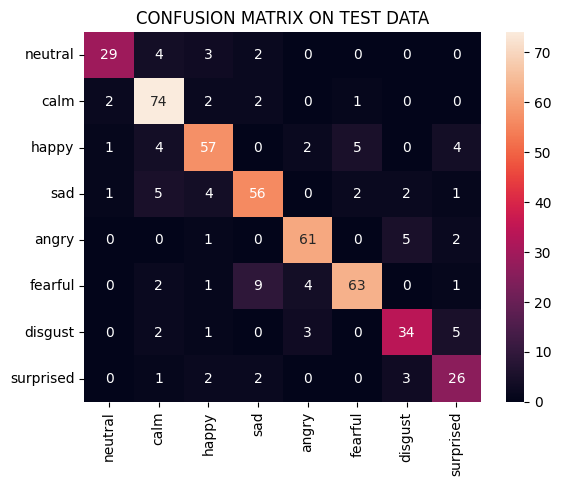

In [465]:
import seaborn as sns
cm=confusion_matrix(y_test,y_pred_classes)
sns.heatmap(cm,annot=True,xticklabels=labels, yticklabels=labels)
plt.title("CONFUSION MATRIX ON TEST DATA")
plt.show()

In [444]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([38, 81, 73, 71, 69, 80, 45, 34]))

In [430]:
import joblib
model.save('model.h5')
joblib.dump(pca,'pca.pkl')
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']




---


---

### OTHER TRIAL

---



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
!pip  -q install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.9/324.9 kB 9.9 MB/s eta 0:00:00


In [77]:
import opensmile
import pandas as pd

# Load a preconfigured feature set: emobase includes pitch, MFCC, shimmer, jitter, etc.
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.emobase,
    feature_level=opensmile.FeatureLevel.Functionals  # gives summarized stats
)

In [160]:
x=[]

In [161]:
for i in range(1, 10):
    folder_path = f"/content/drive/MyDrive/Mars_Dataset/Audio_Speech_Actors_01-24/Actor_0{i}"
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        features_df = smile.process_file(file_path)
        x.append(np.array(features_df.iloc[:,:-1]))







In [162]:
for i in range(10, 25):
    folder_path = f"/content/drive/MyDrive/Mars_Dataset/Audio_Speech_Actors_01-24/Actor_{i}"
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        features_df = smile.process_file(file_path)
        x.append(np.array(features_df.iloc[:,:-1]))


In [163]:
for i in range(1, 10):
    folder_path = f"/content/drive/MyDrive/Mars_Dataset/Audio_Song_Actors_01-24/Actor_0{i}"
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        features_df = smile.process_file(file_path)
        x.append(np.array(features_df.iloc[:,:-1]))

In [164]:
for i in range(10, 25):
    if i==18:
      continue
    folder_path = f"/content/drive/MyDrive/Mars_Dataset/Audio_Song_Actors_01-24/Actor_{i}"
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        features_df = smile.process_file(file_path)
        x.append(np.array(features_df.iloc[:,:-1]))

In [165]:
len(x)

2452

In [188]:
df.head(1)

,features,labels,combined,opensmile_features
0,"[-697.7926025390625, 54.89004135131836, 0.6634...",01,"[-697.7926025390625, 54.89004135131836, 0.6634...","[8.975932e-08, 0.0, 8.975932e-08, 142.0, 0.0, ..."


In [89]:
x[0].shape

(1, 987)

In [95]:
x_combined=[]
for i in range(0,2452):
  x_combined.append(np.hstack([np.array(df.features[i]).reshape(1,556),np.array(x[i])]))


In [99]:
df['combined']=x_combined

In [168]:
df['opensmile_features']=x

In [169]:
df.to_pickle('combined.pkl')

In [189]:
x=df.combined
y=df['labels']

In [193]:
for i in range (len(x)):
  x[i]=x[i].reshape(1543,)

In [194]:
len(x)

2452

In [195]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [196]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [197]:
x_train=np.stack(x_train)
x_test=np.stack(x_test)

In [198]:
x_train.shape

(1961, 1543)

In [199]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [200]:
pca = PCA(n_components=.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
print("PCA-reduced shape:Train", x_train_pca.shape)
print("PCA-reduced shape:Test", x_test_pca.shape)

PCA-reduced shape:Train (1961, 346)
PCA-reduced shape:Test (491, 346)


In [201]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(346,)),
    # Dropout(0.3),
    BatchNormalization(),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [202]:
model.fit(x_train_pca, y_train,validation_data=(x_test_pca, y_test),
    epochs=100,
    batch_size=32,

    callbacks=[early_stop]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2132 - loss: 2.3010 - val_accuracy: 0.2688 - val_loss: 1.8862
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5161 - loss: 1.3751 - val_accuracy: 0.3686 - val_loss: 1.6928
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6963 - loss: 0.9571 - val_accuracy: 0.4807 - val_loss: 1.4764
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7867 - loss: 0.6951 - val_accuracy: 0.5540 - val_loss: 1.2831
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8434 - loss: 0.5385 - val_accuracy: 0.5866 - val_loss: 1.1323
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9120 - loss: 0.3659 - val_accuracy: 0.6110 - val_loss: 1.0708
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9259 - loss: 0.2907 - val_accuracy: 0.5825 - val_loss: 1.0627
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9476 - loss: 0.1933 - val_accuracy: 0.6049